In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [269]:
df = pd.read_excel(r"C:\Users\ASUS\OneDrive\Desktop\ML\Regression - Project\premiums_rest.xlsx")
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


In [270]:
df.shape

(29904, 13)

In [271]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

### Data Cleaning

In [273]:
# Data Inconsistency -> some columns have spaces, others have _

In [274]:
df.columns = df.columns.str.replace(' ', '_').str.lower() #assign it back
df.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053


### Handling NA values

In [276]:
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [277]:
# in context of size of dataset, not that many

In [278]:
df.dropna(inplace = True)

In [279]:
df.duplicated().sum()
df.drop_duplicates(inplace = True)
df.duplicated().sum()


0

In [280]:
df.describe() #For numeric columns

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29886.000000,29886.000000,29886.000000,29886.000000
mean,43.396105,2.379910,23.364184,20892.303821
std,13.412657,1.431201,24.740339,6936.813440
min,26.000000,-3.000000,1.000000,3625.000000
25%,34.000000,1.000000,7.000000,15697.250000
50%,42.000000,3.000000,17.000000,20489.000000
75%,52.000000,3.000000,32.000000,26360.000000
max,356.000000,5.000000,930.000000,43471.000000


In [281]:
# age 356 -> error
# number of dependents is a negative value -> error
# income_lakhs 930 lakhs (9.3 Cr) - > skewed distribution

### Univariate Analysis

In [283]:
df[df.number_of_dependants < 0].shape

(50, 13)

In [284]:
# 72 rows with less than 0 dependents

In [285]:
df[df.number_of_dependants < 0]['number_of_dependants'].unique()

array([-1, -3], dtype=int64)

In [286]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    29886.000000
mean         2.385933
std          1.421137
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

In [287]:
# Vizulaizing Outliers

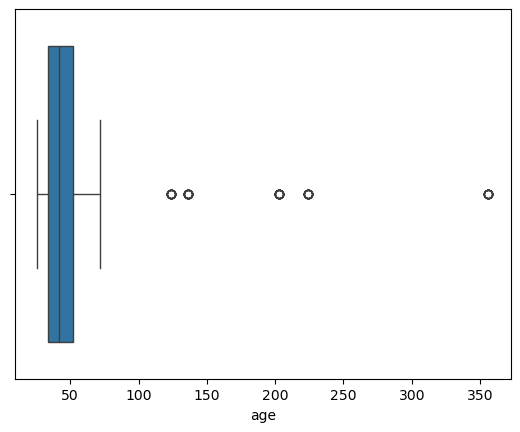

In [288]:
sns.boxplot(x = df['age'])
plt.show()

In [289]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29886 entries, 0 to 29903
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   age                    29886 non-null  int64 
 1   gender                 29886 non-null  object
 2   region                 29886 non-null  object
 3   marital_status         29886 non-null  object
 4   number_of_dependants   29886 non-null  int64 
 5   bmi_category           29886 non-null  object
 6   smoking_status         29886 non-null  object
 7   employment_status      29886 non-null  object
 8   income_level           29886 non-null  object
 9   income_lakhs           29886 non-null  int64 
 10  medical_history        29886 non-null  object
 11  insurance_plan         29886 non-null  object
 12  annual_premium_amount  29886 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 3.2+ MB


In [290]:
# All numeric ones are either float64 or int 64

In [291]:
df.select_dtypes(['float64', 'int64'])

,age,number_of_dependants,income_lakhs,annual_premium_amount
0,26,0,6,9053
1,29,2,6,16339
2,49,2,20,18164
3,30,3,77,20303
4,56,3,14,15610
...,...,...,...,...
29899,60,3,26,26370
29900,40,0,16,29496
29901,37,0,4,10957
29902,47,2,82,27076


In [292]:
df_numeric_columns = df.select_dtypes(['float64', 'int64']).columns
df_numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

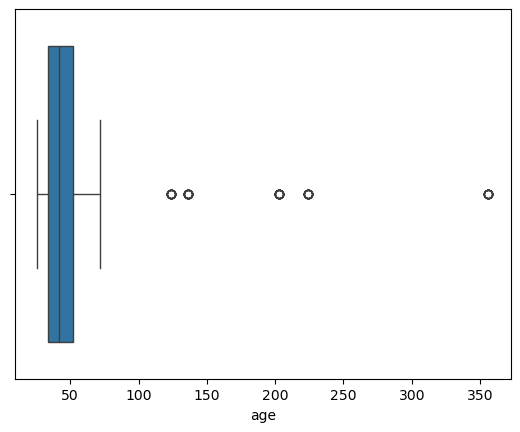

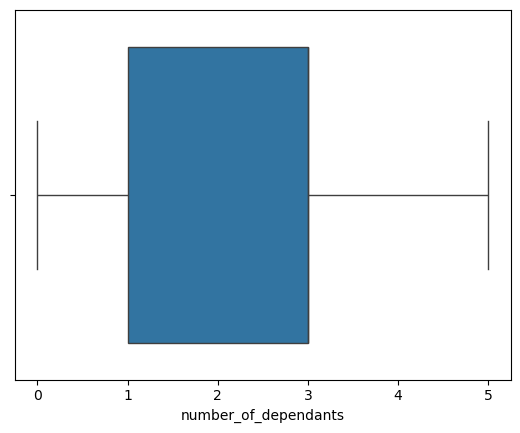

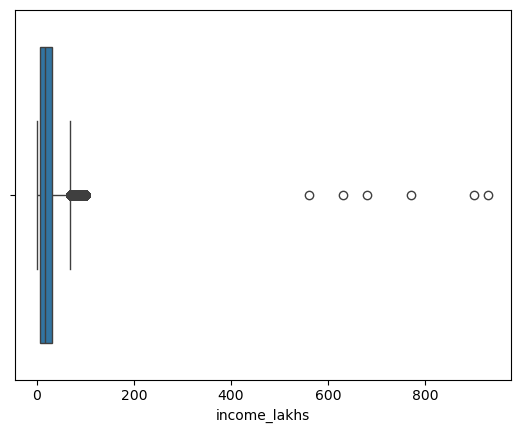

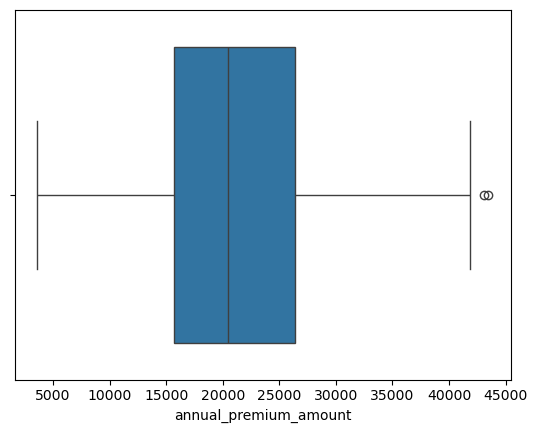

In [293]:
for col in df_numeric_columns:
    sns.boxplot(x = df[col])
    plt.show()
    

In [294]:
df[df.age>100]['age'].value_counts()

age
136    15
203    13
124    11
224    10
356     9
Name: count, dtype: int64

In [295]:
df[df.age>100]['age'].unique()

array([224, 124, 136, 203, 356], dtype=int64)

In [296]:
#we can drop them

In [297]:
df1 = df[df.age <=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29828.000000,29828.000000,29828.000000,29828.000000
mean,43.095380,2.387790,23.371530,20901.900563
std,11.041991,1.420641,24.751262,6928.457636
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15706.000000
50%,42.000000,3.000000,17.000000,20496.000000
75%,52.000000,3.000000,32.000000,26361.000000
max,72.000000,5.000000,930.000000,43471.000000


<Axes: xlabel='income_lakhs', ylabel='Count'>

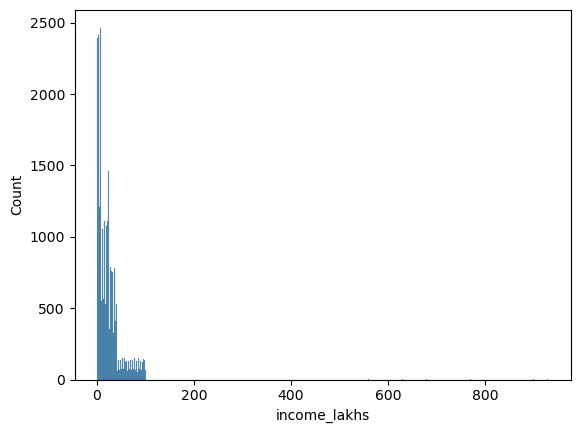

In [298]:
sns.histplot(df1.income_lakhs)

In [299]:
Q1,Q3 = df.income_lakhs.quantile([0.25,0.75])
Q1,Q3

(7.0, 32.0)

In [300]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25,0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    return lower_bound, upper_bound

In [301]:
get_iqr_bounds(df1.income_lakhs)

(-30.5, 69.5)

In [302]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

100.0

In [303]:
df1[df1.income_lakhs > quantile_threshold]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
1598,51,Male,Northwest,Married,4,Obesity,No Smoking,Self-Employed,> 40L,560,High blood pressure,Gold,30692
4657,35,Female,Northeast,Unmarried,0,Overweight,No Smoking,Salaried,> 40L,630,Diabetes,Gold,24010
5399,43,Male,Southeast,Married,3,Obesity,Regular,Salaried,> 40L,900,Diabetes & Thyroid,Gold,30848
6149,37,Female,Southeast,Married,3,Normal,No Smoking,Freelancer,> 40L,930,Diabetes,Silver,15945
21176,59,Male,Northwest,Married,2,Obesity,Occasional,Self-Employed,> 40L,770,Thyroid,Gold,31115
24489,48,Male,Northeast,Married,4,Obesity,No Smoking,Salaried,> 40L,680,No Disease,Gold,28926


In [304]:
df1[df1.income_lakhs > quantile_threshold].shape

(6, 13)

In [305]:
df2 =df1[ df1.income_lakhs <= quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29822.000000,29822.000000,29822.000000,29822.000000
mean,43.094896,2.387734,23.226343,20900.689223
std,11.042430,1.420644,22.455408,6928.192115
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15705.250000
50%,42.000000,3.000000,17.000000,20495.500000
75%,52.000000,3.000000,32.000000,26360.000000
max,72.000000,5.000000,100.000000,43471.000000


In [306]:
# not many outliers in annual_premium_amount -> let it be as is

In [307]:
# histogram -> right skewed, left skewed, the kind of distribution

<Axes: xlabel='income_lakhs', ylabel='Count'>

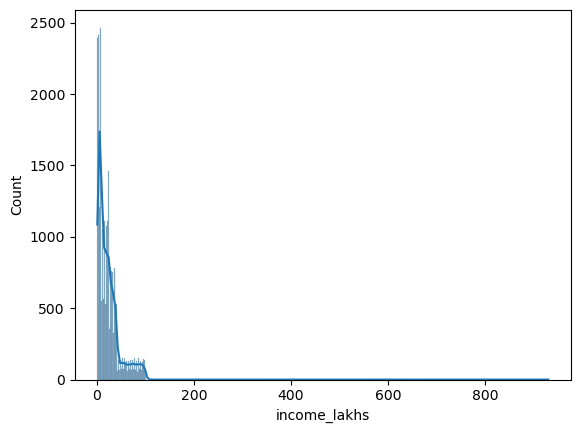

In [308]:
sns.histplot(df1['income_lakhs'],kde = True) # with outliers

<Axes: xlabel='income_lakhs', ylabel='Count'>

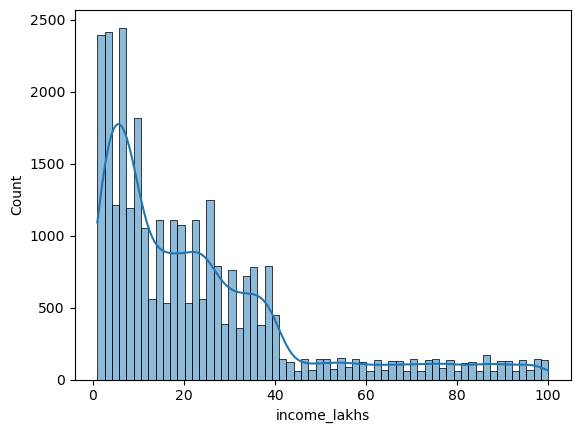

In [309]:
sns.histplot(df2['income_lakhs'],kde = True) # without outliers

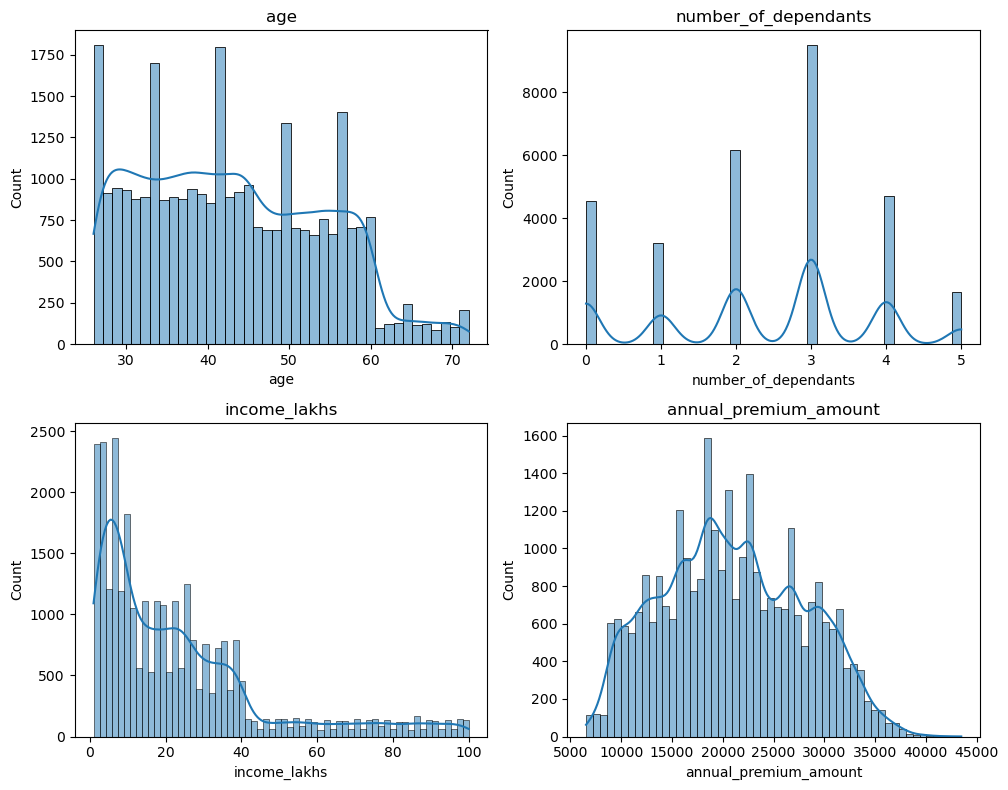

In [310]:
fig,axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

for i,col in enumerate(df_numeric_columns):
    ax = axs[i//2 , i%2] #Determines the position of the subplot in the grid
    sns.histplot(df2[col],kde = True,ax = ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()

### Bivariate Analysis

<Axes: xlabel='age', ylabel='annual_premium_amount'>

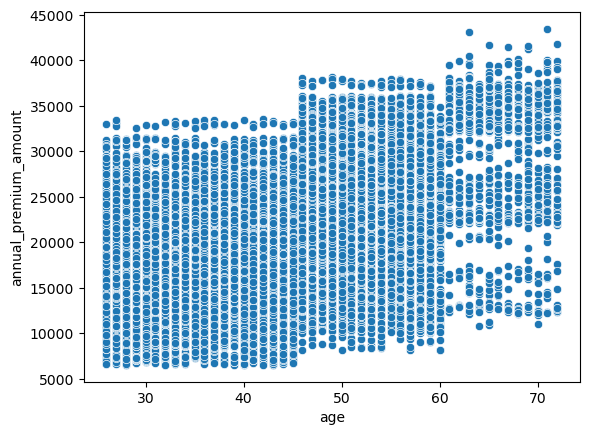

In [312]:
sns.scatterplot(df2, x = 'age', y ='annual_premium_amount')

In [313]:
#age increases, annual premium amount increases -> positive correlation/

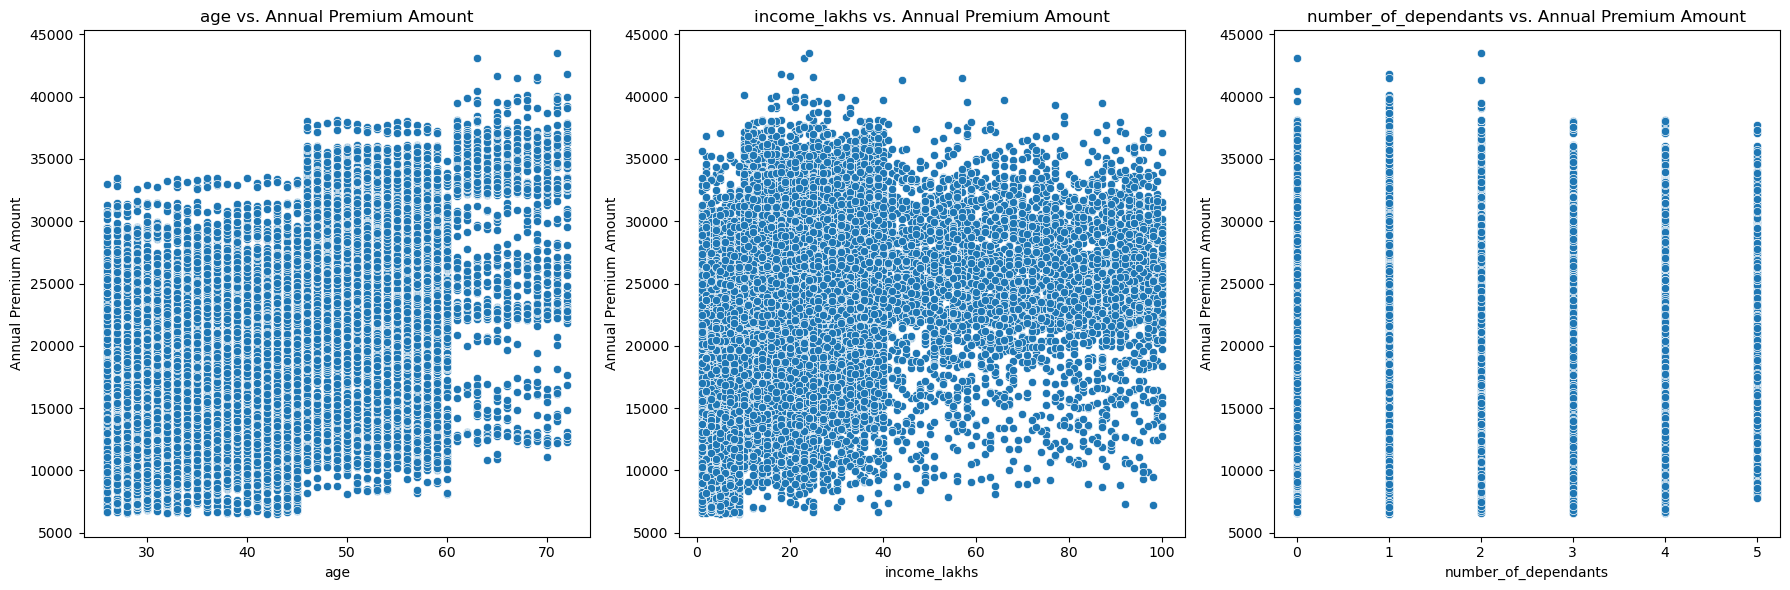

In [314]:
numeric_features = ['age' , 'income_lakhs', 'number_of_dependants']

fig,axes = plt.subplots(1, len(numeric_features), figsize = (18,6)) 

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x = df2[column], y =df2['annual_premium_amount'],ax = ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()
plt.show()

In [315]:
# no clear correlation between income_lakhs and number_of_dependants

In [316]:
categorical_df = df.select_dtypes('object')
categorical_df

,gender,region,marital_status,bmi_category,smoking_status,employment_status,income_level,medical_history,insurance_plan
0,Male,Northwest,Unmarried,Normal,No Smoking,Salaried,<10L,Diabetes,Bronze
1,Female,Southeast,Married,Obesity,Regular,Salaried,<10L,Diabetes,Bronze
2,Female,Northeast,Married,Normal,No Smoking,Self-Employed,10L - 25L,High blood pressure,Silver
3,Female,Southeast,Married,Normal,No Smoking,Salaried,> 40L,No Disease,Gold
4,Male,Northeast,Married,Obesity,Occasional,Self-Employed,10L - 25L,Diabetes,Bronze
...,...,...,...,...,...,...,...,...,...
29899,Female,Northwest,Married,Normal,No Smoking,Self-Employed,25L - 40L,High blood pressure,Gold
29900,Female,Southeast,Unmarried,Overweight,Regular,Salaried,10L - 25L,Diabetes & Thyroid,Gold
29901,Female,Northwest,Unmarried,Obesity,No Smoking,Salaried,<10L,No Disease,Bronze
29902,Female,Southeast,Married,Normal,No Smoking,Salaried,> 40L,Thyroid,Gold


In [317]:
categorical_cols = df.select_dtypes('object').columns
categorical_cols

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [318]:
for col in categorical_cols:
    print(col, ":" , df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [319]:
# presence of non uniform values in smoking_status columns

In [320]:
df2['smoking_status'].replace({
    'Smoking=0' : 'No Smoking',
    'Does Not Smoke' : 'No Smoking',
    'Not Smoking' : 'No Smoking'
} , inplace = True)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_18080\3676593068.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['smoking_status'].replace({


In [321]:
df2['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [322]:
df2.gender.value_counts()

gender
Male      16376
Female    13446
Name: count, dtype: int64

In [323]:
pct_count = df2.gender.value_counts(normalize = True)
pct_count

gender
Male      0.549125
Female    0.450875
Name: proportion, dtype: float64

In [324]:
pct_count.index

Index(['Male', 'Female'], dtype='object', name='gender')

In [325]:
pct_count.values

array([0.54912481, 0.45087519])

<Axes: xlabel='gender'>

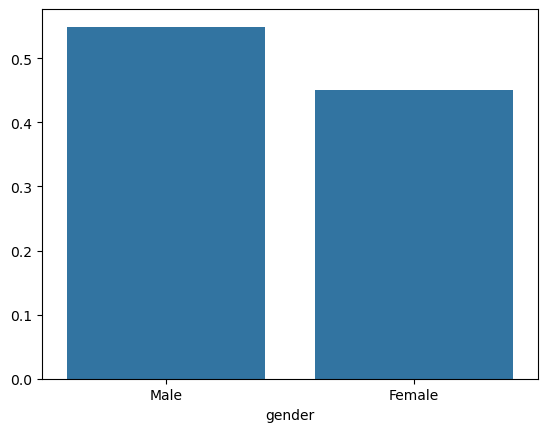

In [326]:
sns.barplot(x = pct_count.index, y = pct_count.values)

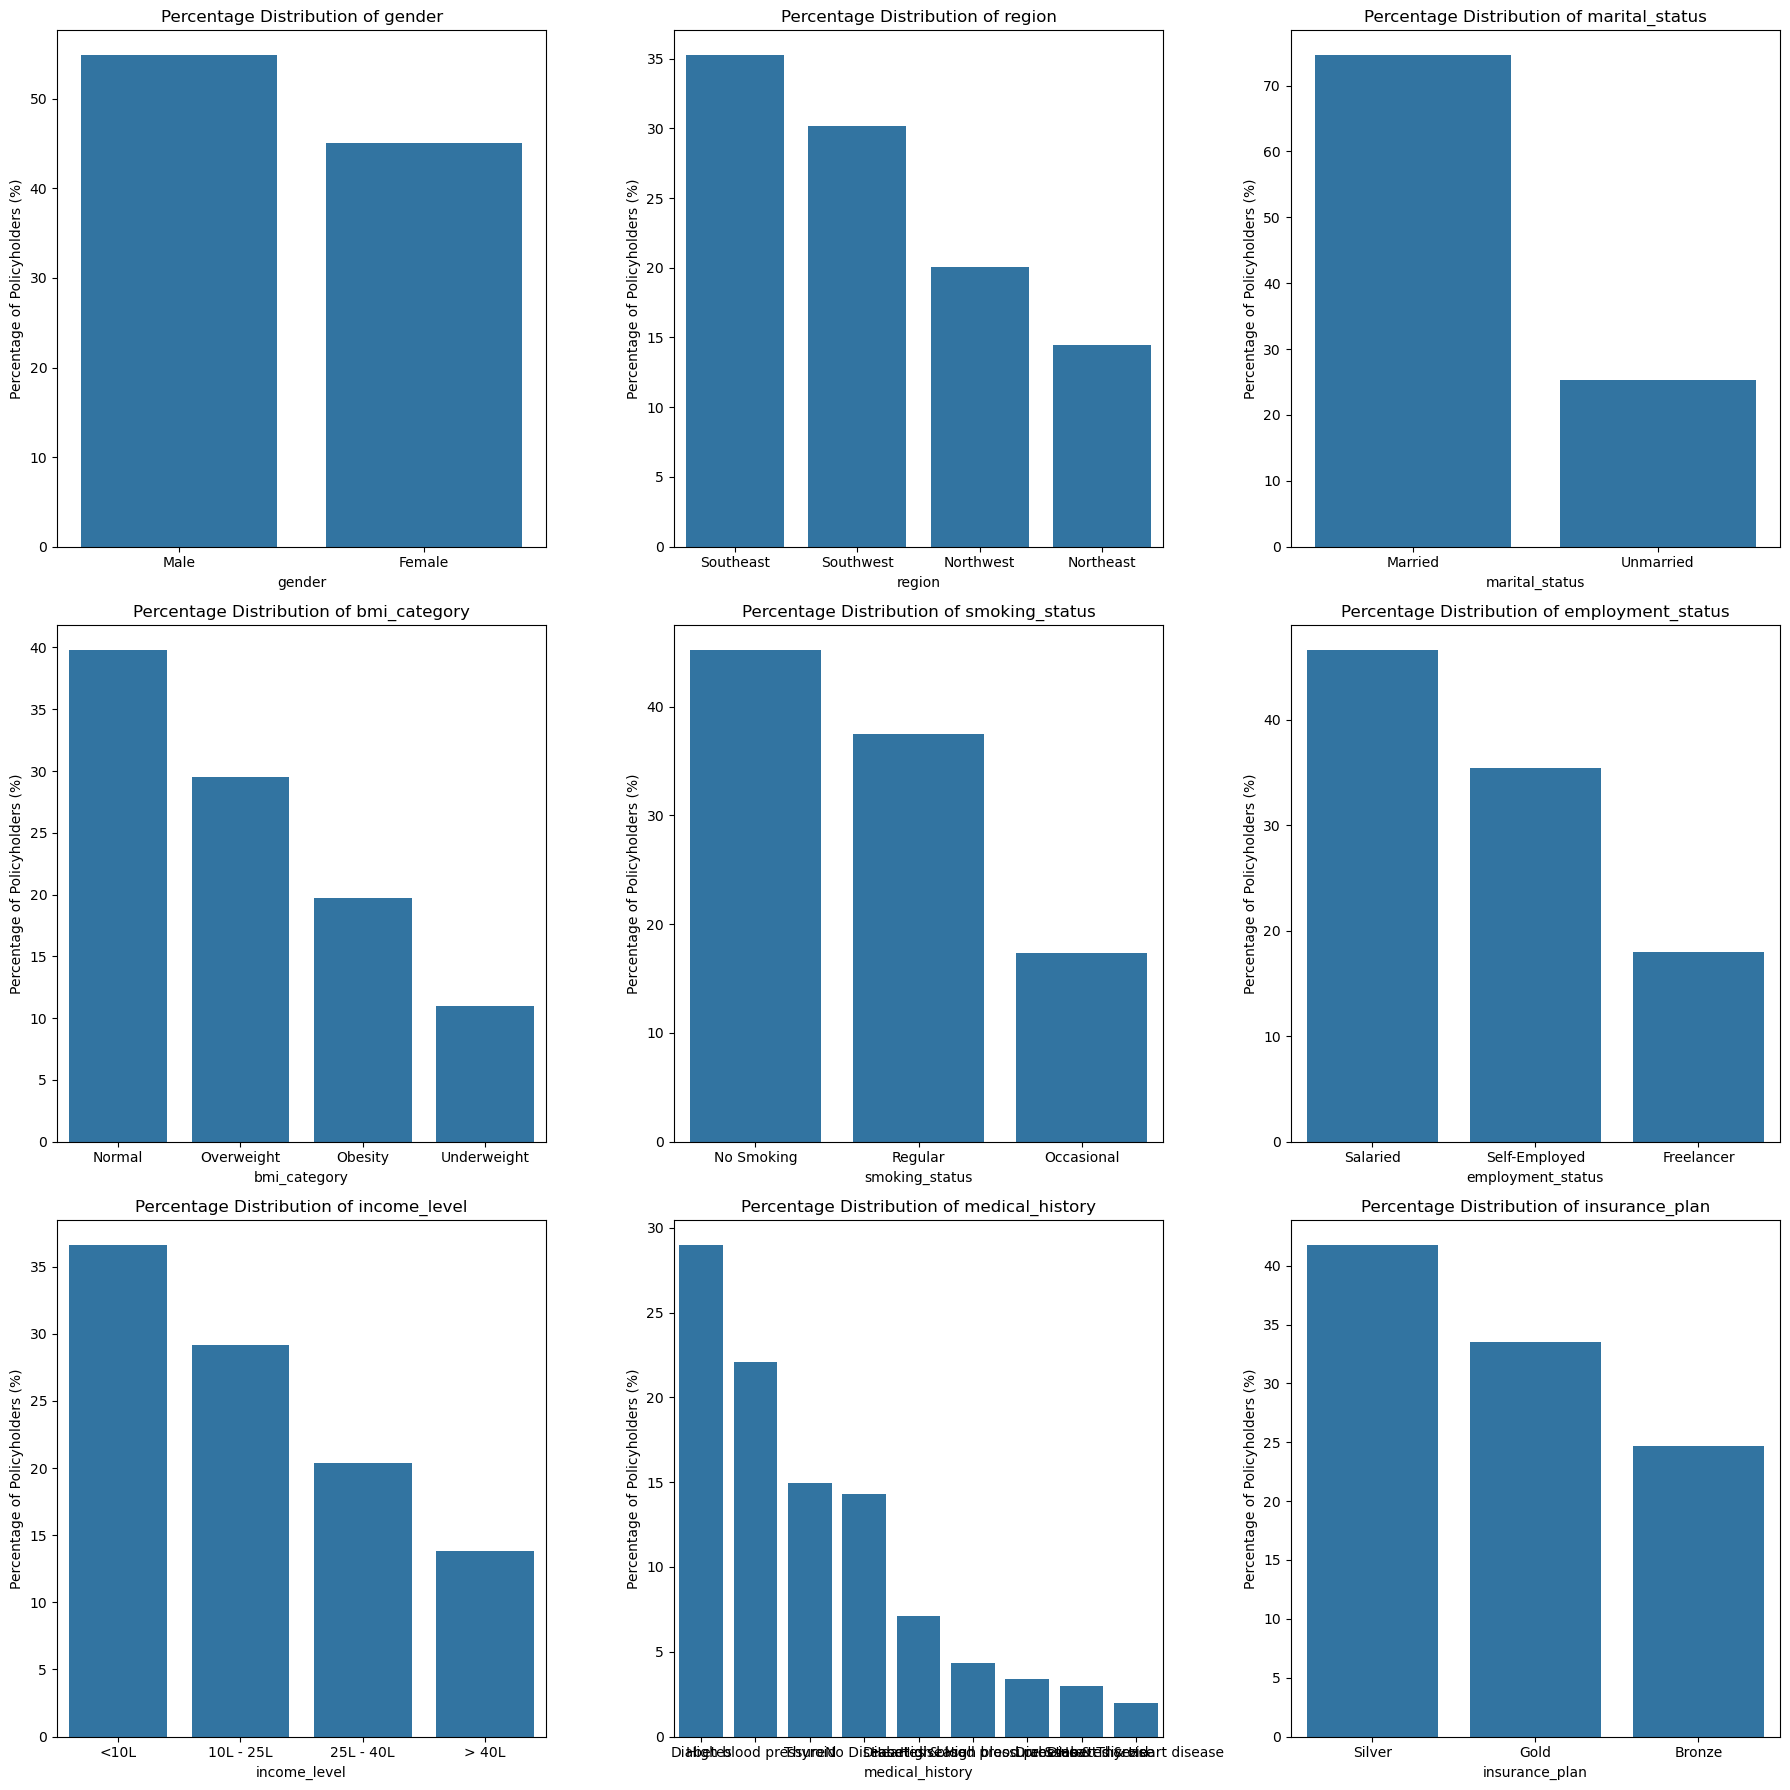

In [327]:
fig,axes = plt.subplots(3,3,figsize = (18,18))
axes = axes.flatten() # flatten the 2D array of axes into 1D for easier iteration

for ax,column in zip (axes, categorical_cols):
    #calc the percentage distribution of each category
    category_counts = df2[column].value_counts(normalize = True) * 100

    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index , y = category_counts.values, ax = ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel(f'Percentage of Policyholders (%)')
    ax.set_xlabel(column) 

plt.tight_layout()
plt.show()

In [328]:
crosstab = pd.crosstab(df2['income_level'] , df2['insurance_plan'])
crosstab

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,799,3554,4354
25L - 40L,301,2631,3142
<10L,6054,527,4341
> 40L,214,3287,618


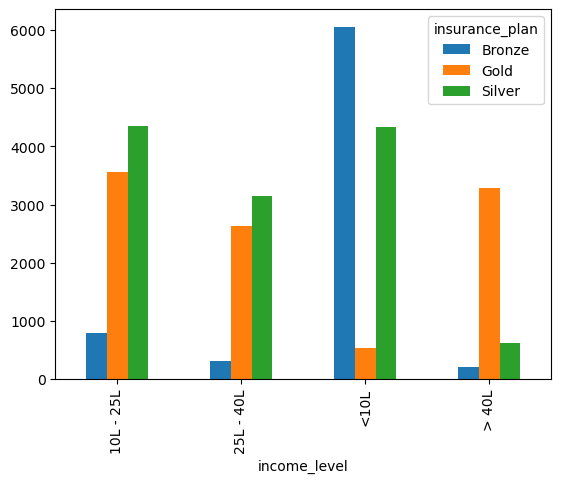

In [329]:
crosstab.plot(kind = "bar")
plt.show()

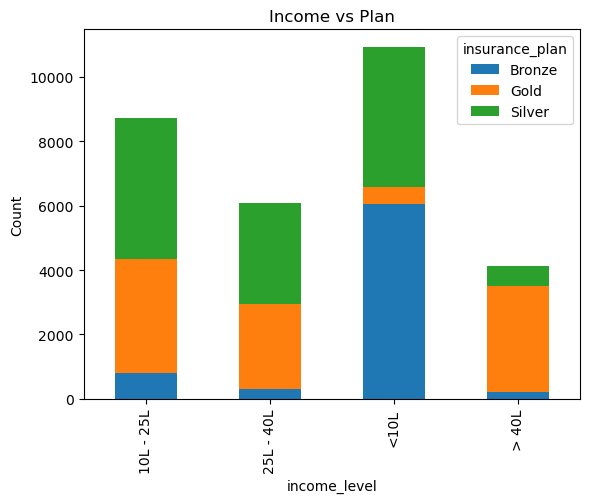

In [330]:
crosstab.plot(kind = "bar",stacked = True)
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='insurance_plan', ylabel='income_level'>

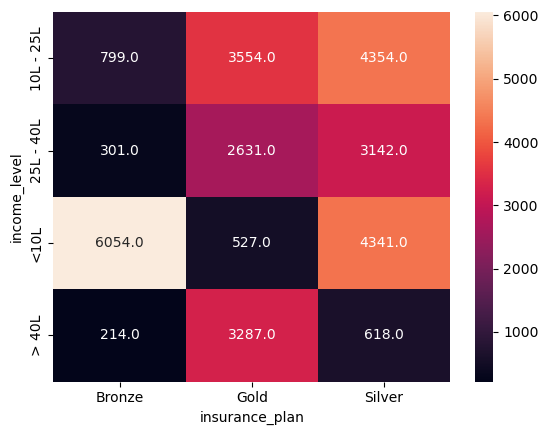

In [331]:
sns.heatmap(crosstab, annot = True, fmt = '.1f')

In [332]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339


In [333]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [334]:
# higher number of pre-existing diseases -> higher premium

In [335]:
risk_score = {
    "diabetes" : 6,
    "heart disease": 8,
    "high blood pressure" : 6,
    "thyroid" : 5,
    "no disease" : 0,
    "none" : 0
}

df2['medical_history'].str.split(" & ")

0                   [Diabetes]
1                   [Diabetes]
2        [High blood pressure]
3                 [No Disease]
4                   [Diabetes]
                 ...          
29899    [High blood pressure]
29900      [Diabetes, Thyroid]
29901             [No Disease]
29902                [Thyroid]
29903               [Diabetes]
Name: medical_history, Length: 29822, dtype: object

In [336]:
df2['medical_history'].str.split(" & ", expand = True)

,0,1
0,Diabetes,None
1,Diabetes,None
2,High blood pressure,None
3,No Disease,None
4,Diabetes,None
...,...,...
29899,High blood pressure,None
29900,Diabetes,Thyroid
29901,No Disease,None
29902,Thyroid,None


In [337]:
df2['medical_history'].str.split(" & ", expand = True).apply(lambda x: x.str.lower()).sample(10)

,0,1
22434,heart disease,None
3072,high blood pressure,None
17559,diabetes,None
19425,heart disease,None
29499,diabetes,None
14206,diabetes,None
660,diabetes,None
2390,thyroid,None
21499,high blood pressure,None
13472,diabetes,heart disease


In [338]:
df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ",expand = True).apply(lambda x : x.str.lower())
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,None


In [339]:
df2['disease1'].fillna('none',inplace = True)
df2['disease2'].fillna('none',inplace = True)
df2['total_risk_score'] = 0 

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_score)

max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_18080\914496287.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['disease1'].fillna('none',inplace = True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_18080\914496287.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, w

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none,0,0.000000
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,diabetes,none,6,0.428571


In [340]:
df2.insurance_plan.unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [341]:
# ordinal (order) category -> label encoding

In [342]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze' : 1, 'Silver' : 2, 'Gold' : 3})
df2.insurance_plan.unique()

array([1, 2, 3], dtype=int64)

In [343]:
df2['income_level'].unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [344]:
df2['income_level'] = df2['income_level'].map({'<10L': 1, '10L - 25L': 2, '25L - 40L' : 3, '> 40L' : 4})
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571


In [345]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns = nominal_cols, drop_first = True, dtype = int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,no disease,none,0,...,1,0,0,0,0,0,0,0,1,0
4,56,3,2,14,Diabetes,1,15610,diabetes,none,6,...,0,0,0,1,0,0,1,0,0,1


In [346]:
df4 = df3.drop(['medical_history', 'disease1', 'disease2', 'total_risk_score'], axis = 1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,56,3,2,14,1,15610,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


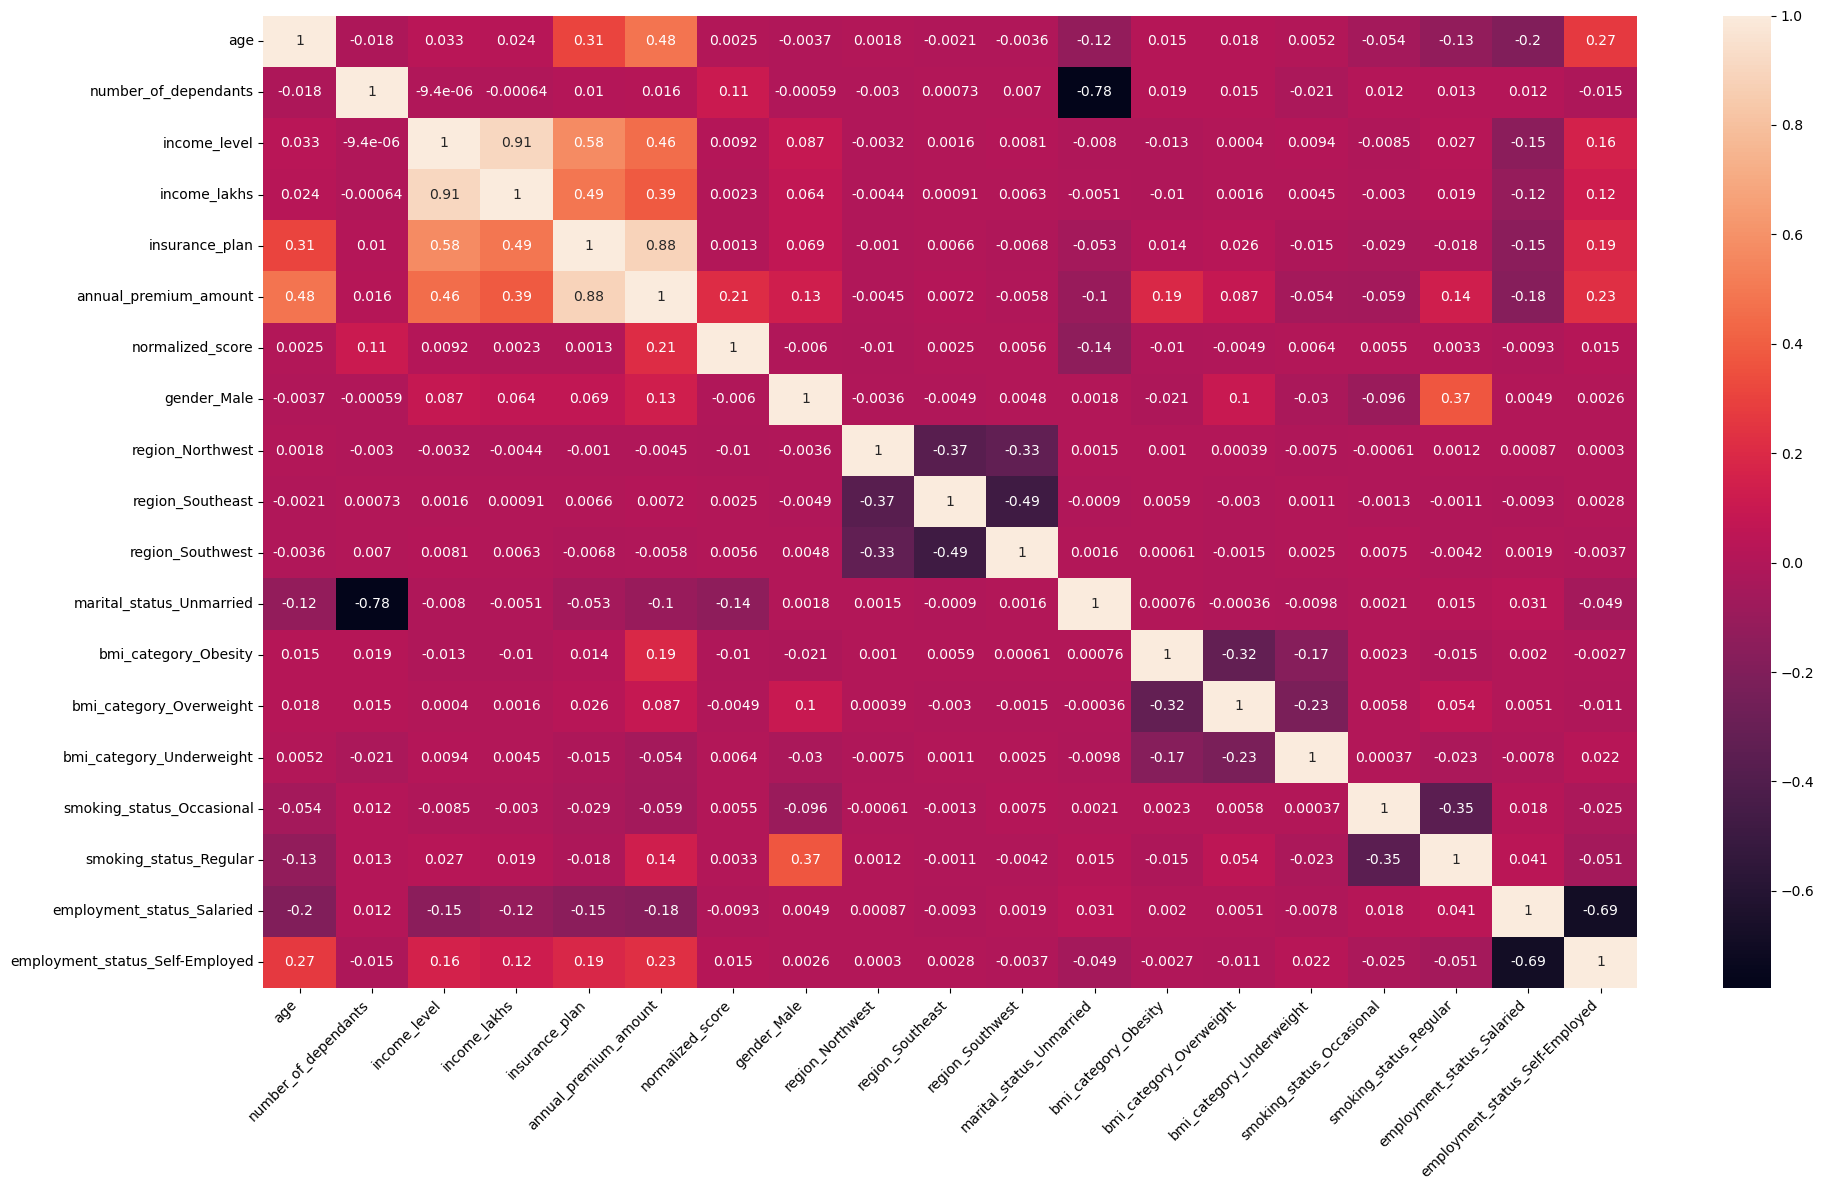

In [347]:
cm = df4.corr()

plt.figure(figsize = (20,12))
sns.heatmap(cm, annot = True)
plt.xticks(rotation = 45, ha ='right')
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

In [348]:
df4.head(2)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0


In [349]:
X = df4.drop('annual_premium_amount', axis = 'columns')
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler
cols_to_scale = ['age','number_of_dependants','income_level','income_lakhs','insurance_plan',]

scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.head()


,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.000000,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.000000,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.333333,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,1.000000,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.333333,0.131313,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


In [350]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Variable'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [351]:
calculate_vif(X)

,Variable,VIF
0,age,3.921783
1,number_of_dependants,6.278938
2,income_level,13.890522
3,income_lakhs,11.185596
4,insurance_plan,5.271297
5,normalized_score,3.810619
6,gender_Male,2.599098
7,region_Northwest,2.123965
8,region_Southeast,2.980842
9,region_Southwest,2.710097


In [352]:
#income level and income lakhs vif higher than 10 - they are extremely correlated.

In [353]:
calculate_vif(X.drop('income_level', axis = 'columns'))

,Variable,VIF
0,age,3.863055
1,number_of_dependants,6.278147
2,income_lakhs,2.678102
3,insurance_plan,4.574625
4,normalized_score,3.808345
5,gender_Male,2.591439
6,region_Northwest,2.123277
7,region_Southeast,2.979899
8,region_Southwest,2.708641
9,marital_status_Unmarried,2.345757


In [354]:
X_reduced = X.drop('income_level', axis = 'columns')
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.131313,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


### Model Training

In [356]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced,y, test_size = 0.3, random_state = 10)

In [357]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

train_score = model_lr.score(X_train,y_train)
test_score = model_lr.score(X_test,y_test)

train_score,test_score

(0.9534163989489616, 0.9538448451629948)

In [358]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test,y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE:  2183844.360312456 RMSE:  1477.7835972538253


In [359]:
# both same, sometimes if train score is greater than test score than it is overfitting

In [360]:
X_test.head(1)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
19713,0.652174,0.0,0.262626,1.0,0.428571,0,0,0,1,1,0,0,0,0,0,0,1


In [361]:
model_lr.coef_

array([ 7016.23932829, -1311.76470171,  -708.19336921, 14835.98820801,
        6053.6241234 ,    37.55826883,   -55.25087215,   -19.62254288,
         -22.28967559,  -700.32019985,  3926.8127061 ,  1979.45604663,
         612.86623617,   837.3951011 ,  2800.66184334,   -45.49136706,
         243.07842087])

In [362]:
model_lr.intercept_

5935.981289344605

In [363]:
X_test.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'normalized_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

In [364]:
feature_importances = model_lr.coef_ #other models have a feature importance function. LR -> coefficients

coef_df = pd.DataFrame(feature_importances,index = X_test.columns, columns = ['Coefficients'])
coef_df = coef_df.sort_values(by = 'Coefficients' , ascending = True)
coef_df

,Coefficients
number_of_dependants,-1311.764702
income_lakhs,-708.193369
marital_status_Unmarried,-700.320200
region_Northwest,-55.250872
employment_status_Salaried,-45.491367
region_Southwest,-22.289676
region_Southeast,-19.622543
gender_Male,37.558269
employment_status_Self-Employed,243.078421
bmi_category_Underweight,612.866236


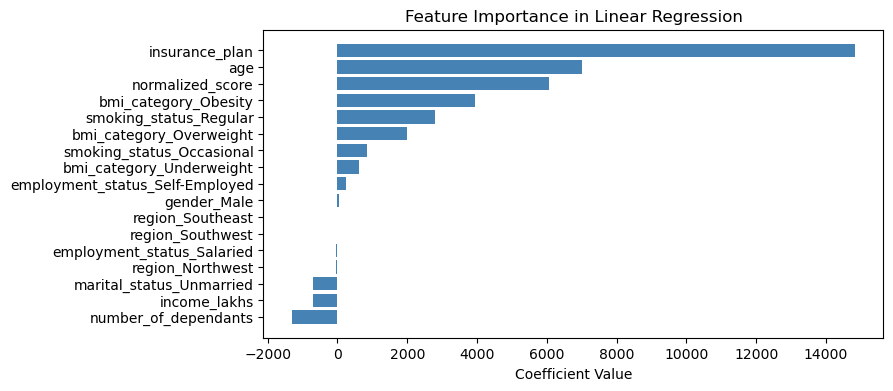

In [365]:
plt.figure(figsize = (8,4))
plt.barh(coef_df.index, coef_df['Coefficients'], color = 'steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

In [366]:
model_rg = Ridge()
model_rg.fit(X_train,y_train)
train_score = model_rg.score(X_train,y_train)
test_Score = model_rg.score(X_test,y_test)
train_score,test_score

(0.9534162332209687, 0.9538448451629948)

In [367]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train,y_train)
train_score = model_xgb.score(X_train,y_train)
test_Score = model_xgb.score(X_test,y_test)
train_score,test_score

(0.9986370761718086, 0.9538448451629948)

In [368]:
y_pred = model_xgb.predict(X_test)

mse_lr = mean_squared_error(y_test,y_pred)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  96814.21540071907 RMSE:  311.14982789762087


In [369]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators' : [20,40,50],
    'learning_rate' : [0.01,0.1,0.2],
    'max_depth' : [3,4,5]
}

random_search = RandomizedSearchCV(model_xgb,param_grid, n_iter = 10, cv = 3, scoring = 'r2', random_state = 42)
random_search.fit(X_train, y_train)
random_search.best_score_

0.9970577807993951

In [370]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [371]:
best_model = random_search.best_estimator_

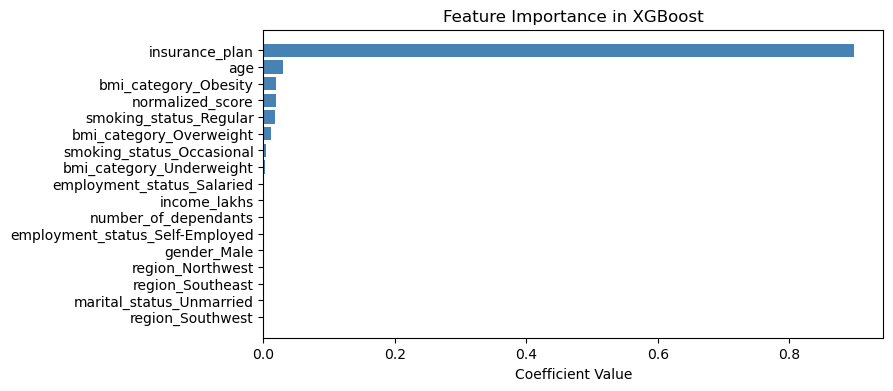

In [372]:
feature_importances = best_model.feature_importances_

coef_df = pd.DataFrame(feature_importances,index = X_test.columns, columns = ['Coefficients'])
coef_df = coef_df.sort_values(by = 'Coefficients' , ascending = True)

plt.figure(figsize = (8,4))
plt.barh(coef_df.index, coef_df['Coefficients'], color = 'steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

In [373]:
# AS XGBoost is tree-based, interpretation of feature importance is not as straightforward as Linear Regression

### Error Analysis

In [375]:
# Can't rely only on R2 score to deploy the model. Need to find the margin of error in each of the sample

In [376]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = (residuals*100)/y_test

results_df = pd.DataFrame ({
    'actual' : y_test,
    'predicted' : y_pred,
    'Delta' : residuals,
    'Delta_pct' : residuals_pct
})
results_df.head()

,actual,predicted,Delta,Delta_pct
19713,26895,26691.470703,-203.529297,-0.756755
14750,22734,22650.751953,-83.248047,-0.366183
19932,21198,21581.894531,383.894531,1.810994
29643,9100,9425.934570,325.934570,3.581699
17076,26434,26691.470703,257.470703,0.974013


<Axes: xlabel='Delta_pct', ylabel='Count'>

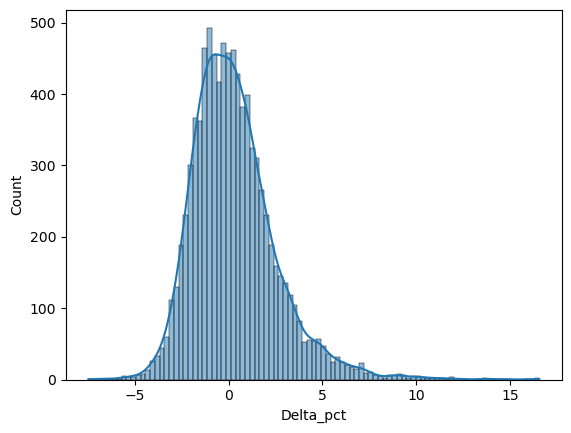

In [377]:
sns.histplot(results_df['Delta_pct'], kde = True)

In [378]:
# how many records with more than 10% error

In [379]:
extreme_threshold = 10

extreme_results_df = results_df[np.abs(results_df.Delta_pct) > extreme_threshold]
extreme_results_df.shape

(29, 4)

In [380]:
results_df.shape

(8947, 4)

In [381]:
extreme_error_pct = extreme_results_df.shape[0] * 100 / results_df.shape[0]
extreme_error_pct

0.32413099362914943

In [382]:
results_df[np.abs(results_df.Delta_pct) > 50].sort_values('Delta_pct',ascending = False)

,actual,predicted,Delta,Delta_pct


In [383]:
extreme_results_df.index

Index([14286, 27518,  9285,  7547, 21910, 12189, 21141, 16263,  8216, 13973,
        9150, 24145, 18522,  6163, 18681, 19145, 21455, 22666,  7508, 10741,
        6517, 18834, 13744, 24119,  2695, 25658, 11019, 14037,  7654],
      dtype='int64')

In [384]:
#high margin errors in X_test

In [385]:
extreme_error_df = X_test.loc[extreme_results_df.index]
extreme_error_df

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
14286,0.021739,0.6,0.050505,0.0,0.000000,1,1,0,0,1,0,0,0,0,0,1,0
27518,0.304348,0.6,0.080808,0.0,0.357143,1,1,0,0,0,0,0,0,0,0,0,1
9285,0.326087,0.6,0.010101,0.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
7547,0.347826,0.2,0.080808,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,1,0
21910,0.043478,0.6,0.020202,0.0,0.000000,1,0,1,0,0,0,0,0,0,0,0,0
12189,0.043478,0.6,0.060606,0.0,0.000000,1,0,0,1,0,0,0,0,0,0,1,0
21141,0.239130,0.6,0.000000,0.0,0.857143,0,0,0,1,0,0,0,0,0,0,0,1
16263,0.673913,0.6,0.383838,0.0,0.000000,1,1,0,0,0,0,0,0,0,0,0,0
8216,0.152174,0.4,0.010101,0.0,0.000000,0,0,0,0,0,0,0,0,0,0,1,0
13973,0.152174,0.8,0.030303,0.0,0.857143,0,1,0,0,0,0,0,0,0,0,0,1


In [386]:
# is error rate highre in specific income group

<Axes: xlabel='income_lakhs', ylabel='Count'>

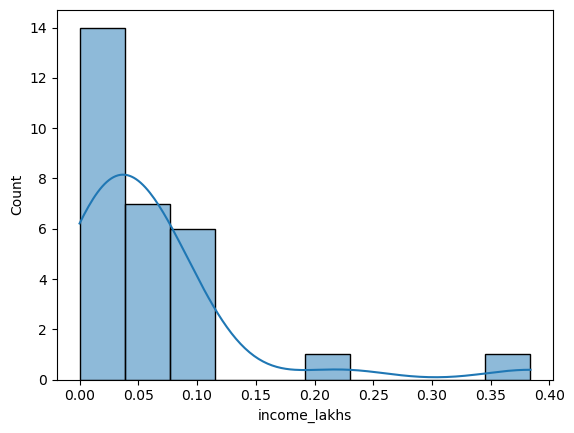

In [387]:
sns.histplot(extreme_error_df.income_lakhs, kde = True)

In [388]:
# No insight need some base case to compare it against

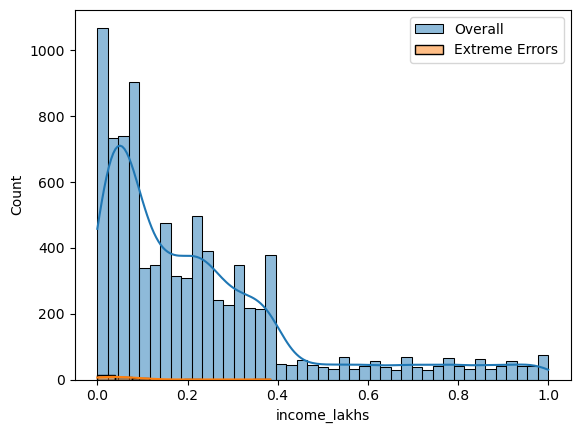

In [389]:
sns.histplot(X_test.income_lakhs, label = "Overall" , kde = True)
sns.histplot(extreme_error_df.income_lakhs,label = "Extreme Errors", kde = True)
plt.legend()
plt.show()

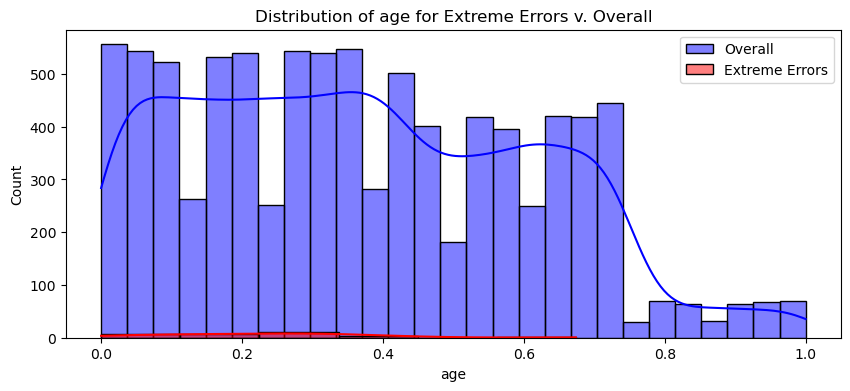

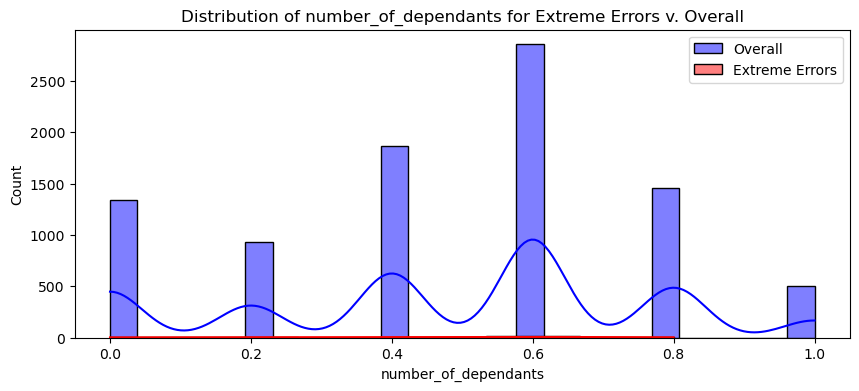

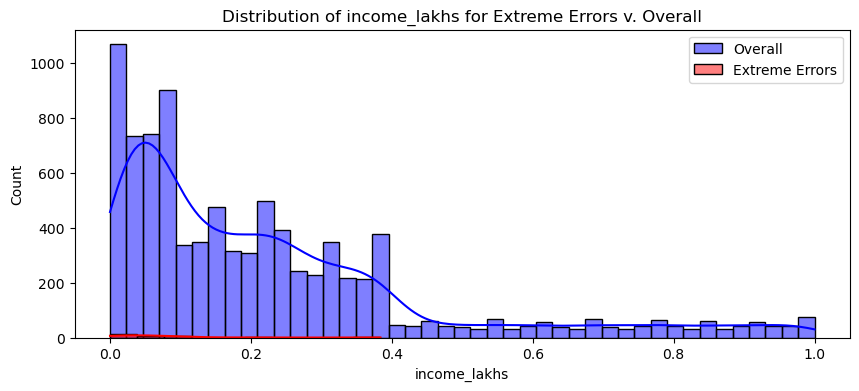

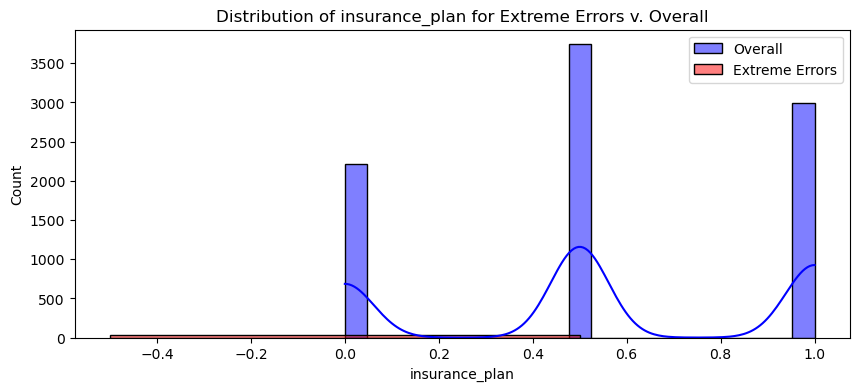

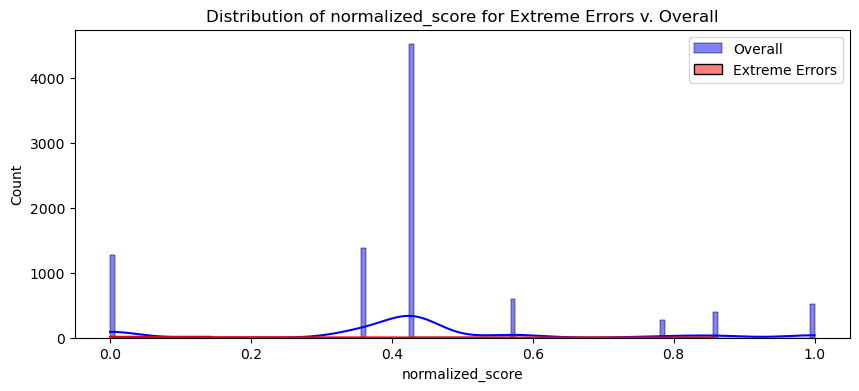

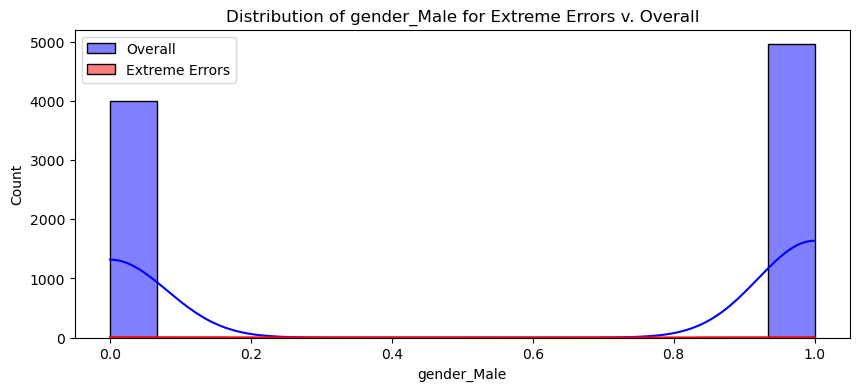

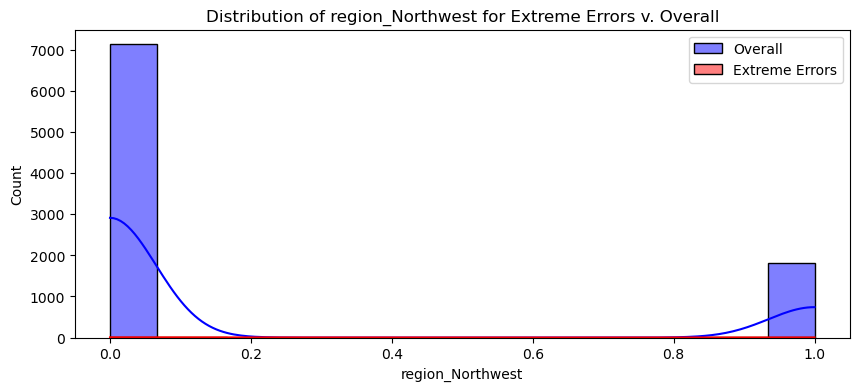

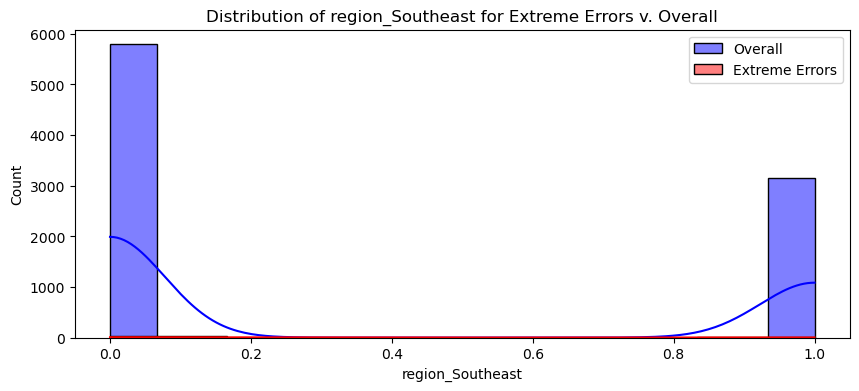

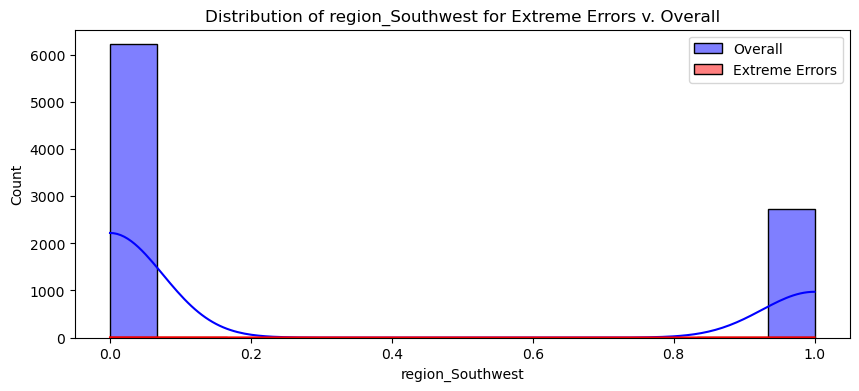

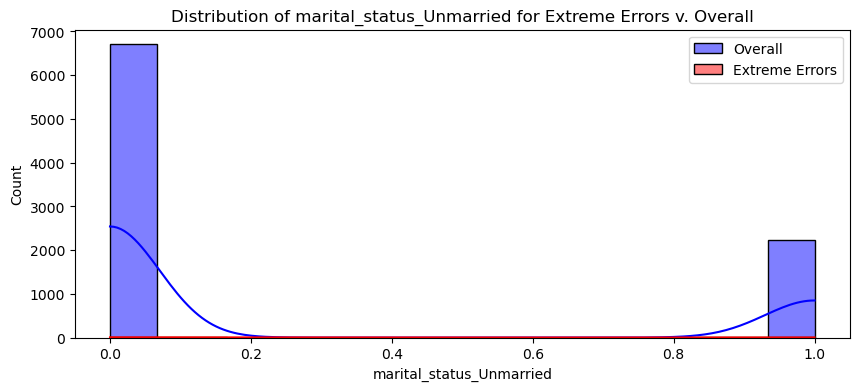

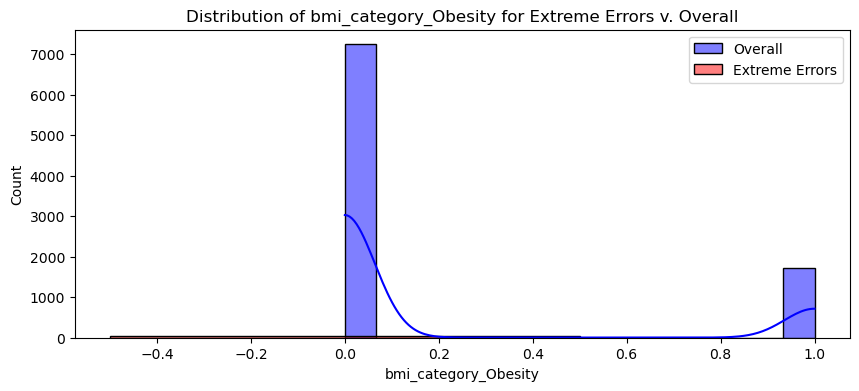

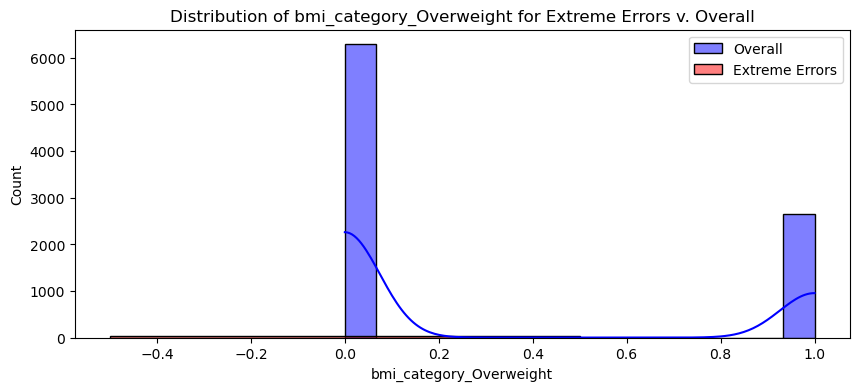

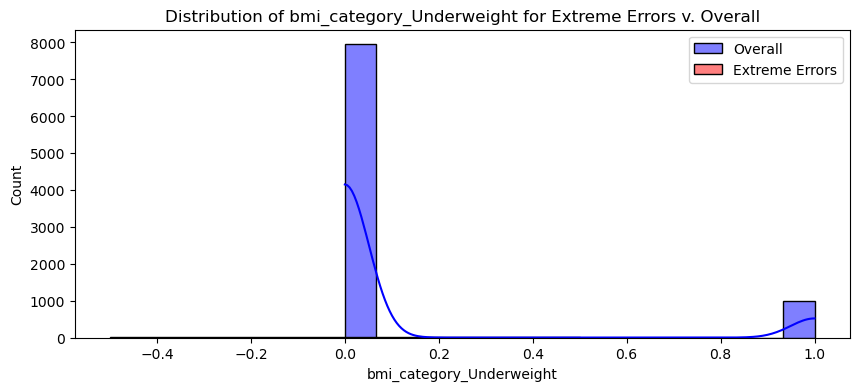

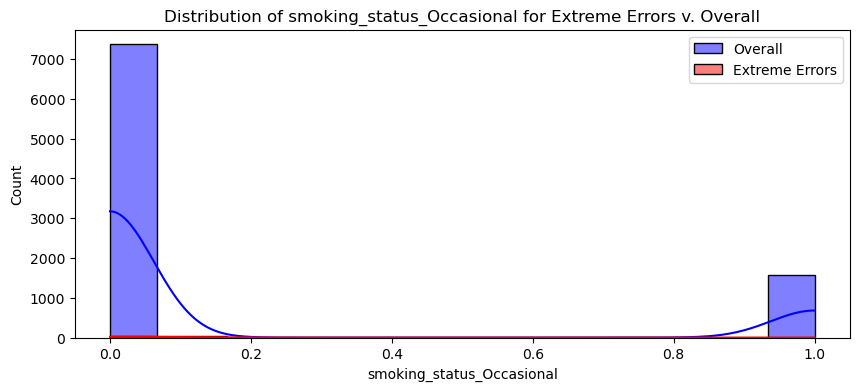

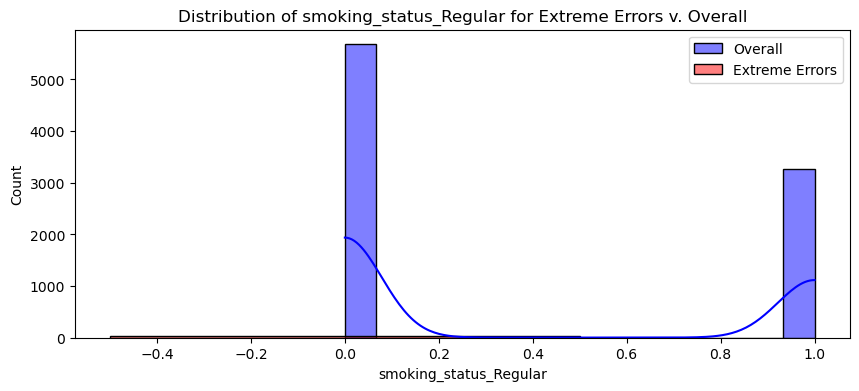

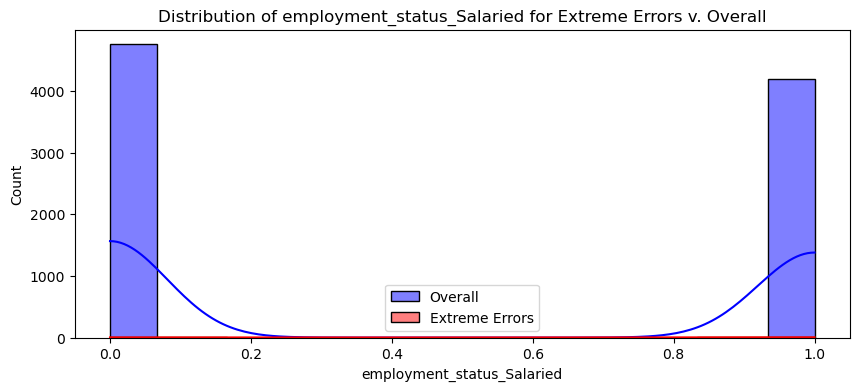

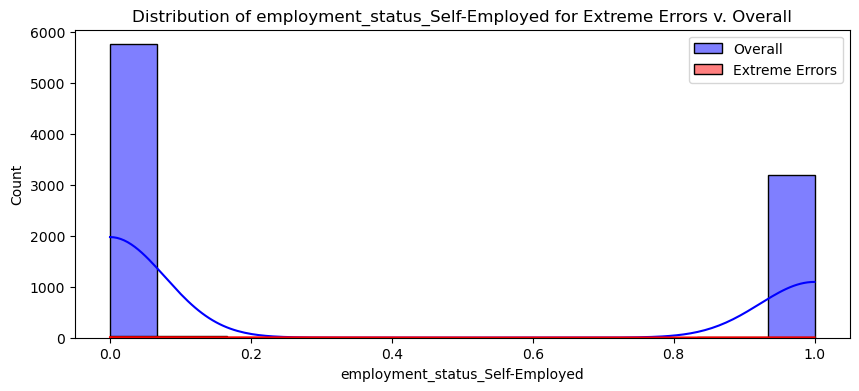

In [390]:
for feature in X_test.columns:
    plt.figure(figsize = (10,4))
    sns.histplot(X_test[feature],color = 'blue', label = "Overall" , alpha = 0.5,kde = True)
    sns.histplot(extreme_error_df[feature], color = 'red', label = "Extreme Errors", kde = True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors v. Overall')
    plt.show()

frequencies in X test are similar to frequencies of Extreme Erros

AGE COLUMN - ERRORS ARE HIGH IN LOWER AGE GROUP

<Axes: xlabel='age', ylabel='Count'>

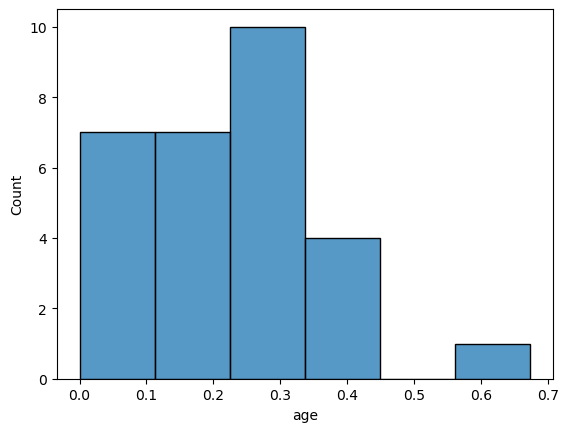

In [393]:
sns.histplot(extreme_error_df.age)

In [394]:
extreme_error_df.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'normalized_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

In [395]:
extreme_error_df['income_level'] = -1 #don't necessarily need the column but need for the object to work

In [396]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_error_df[cols_to_scale])
df_reversed

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,27.0,3.0,-2.0,6.0,1.0
1,40.0,3.0,-2.0,9.0,1.0
2,41.0,3.0,-2.0,2.0,1.0
3,42.0,1.0,-2.0,9.0,1.0
4,28.0,3.0,-2.0,3.0,1.0
5,28.0,3.0,-2.0,7.0,1.0
6,37.0,3.0,-2.0,1.0,1.0
7,57.0,3.0,-2.0,39.0,1.0
8,33.0,2.0,-2.0,2.0,1.0
9,33.0,4.0,-2.0,4.0,1.0


<Axes: xlabel='age', ylabel='Count'>

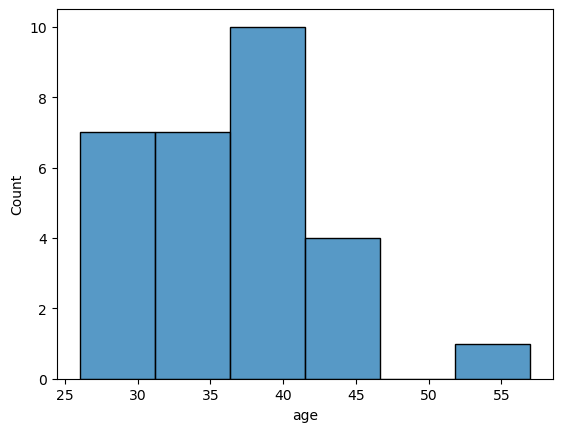

In [397]:
sns.histplot(df_reversed['age'])

In [398]:
df_reversed['age'].describe()

count    29.000000
mean     36.586207
std       6.811321
min      26.000000
25%      32.000000
50%      37.000000
75%      40.000000
max      57.000000
Name: age, dtype: float64

### For rest of age dataset, model is working perfectly fine